In [2]:
%matplotlib inline
from pyspark import SparkContext,SparkConf
from operator import add
from pyspark.sql import SparkSession,Row
from pandas import *
from pyspark.sql.functions import *
from pyspark.sql.functions import *
from pyspark.ml.feature import Bucketizer
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import re
spark = SparkSession \
    .builder \
    .appName("pyspark") \
    .config("spark.some.config.option", "some-value") \
    .enableHiveSupport()\
    .getOrCreate()
sc=spark.sparkContext
userPath="data/ml-100k/u.user"
rawdata=sc.textFile(userPath)
rawdata.first()
pattern = re.compile(r"[^\d+]")
data=rawdata.map(lambda x:x.split("|"))
def f(x):
    print x
data.filter(lambda x:pattern.match(x[4]))
data=data.map(lambda x:(int(x[0]),int(x[1]),x[2],x[3],str(x[4])))
User = Row('id','age','gender','occupation','zip_code')
user = data.map(lambda r:User(*r))
userDf = spark.createDataFrame(user)
# userDf.limit(5).show()
# userDf.describe(['age']).show()
userDf.registerTempTable("user")
sqlString="with t1 as (select count(distinct(age)) as ages from user),\
           t2 as (select count(distinct(gender)) as genders from user), \
           t3 as (select count(distinct(occupation)) as occupations from user) \
            select * from t1 cross join t2 cross join t3"
spark.sql(sqlString).show()
nf=userDf.select(userDf.id,userDf.age.cast(DoubleType()),userDf.gender,userDf.occupation,userDf.zip_code)
bucketizer = Bucketizer(splits=range(5,80,10),\
            inputCol="age", outputCol="newage")
nf=bucketizer.setHandleInvalid("keep").transform(nf)
nf=nf.select(nf.id,nf.age.cast(IntegerType()),nf.newage.cast(IntegerType()),nf.gender,nf.occupation,nf.zip_code)
# nf.limit(10).show()
ageDf=nf.groupBy(nf.newage).count().sort(asc("newage"))
ageDf.show()
occupationDf=nf.groupBy(nf.occupation).count().sort(asc("occupation"))
occupationDf.show()
genderDf=nf.groupBy(nf.gender).count().sort(asc("gender"))
genderDf.show()
# ageDf=ageDf.toPandas()
# ageDf.index=["5-15","15-25","25-35","35-45","45-55","55-65","65-75"]
# ageDf=ageDf.loc[:,'count']
# ageDf.plot(kind='bar',color='lightblue')

+----+-------+-----------+
|ages|genders|occupations|
+----+-------+-----------+
|  61|      2|         21|
+----+-------+-----------+

+------+-----+
|newage|count|
+------+-----+
|     0|   11|
|     1|  223|
|     2|  310|
|     3|  194|
|     4|  142|
|     5|   51|
|     6|   12|
+------+-----+

+-------------+-----+
|   occupation|count|
+-------------+-----+
|administrator|   79|
|       artist|   28|
|       doctor|    7|
|     educator|   95|
|     engineer|   67|
|entertainment|   18|
|    executive|   32|
|   healthcare|   16|
|    homemaker|    7|
|       lawyer|   12|
|    librarian|   51|
|    marketing|   26|
|         none|    9|
|        other|  105|
|   programmer|   66|
|      retired|   14|
|     salesman|   12|
|    scientist|   31|
|      student|  196|
|   technician|   27|
+-------------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|     F|  273|
|     M|  670|
+------+-----+



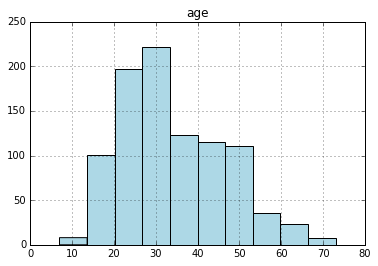

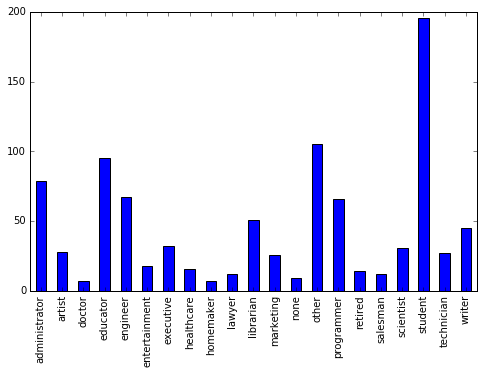

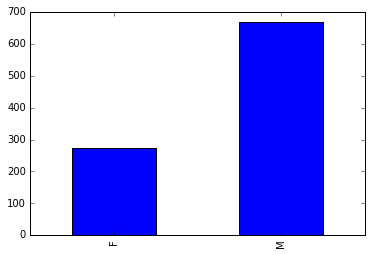

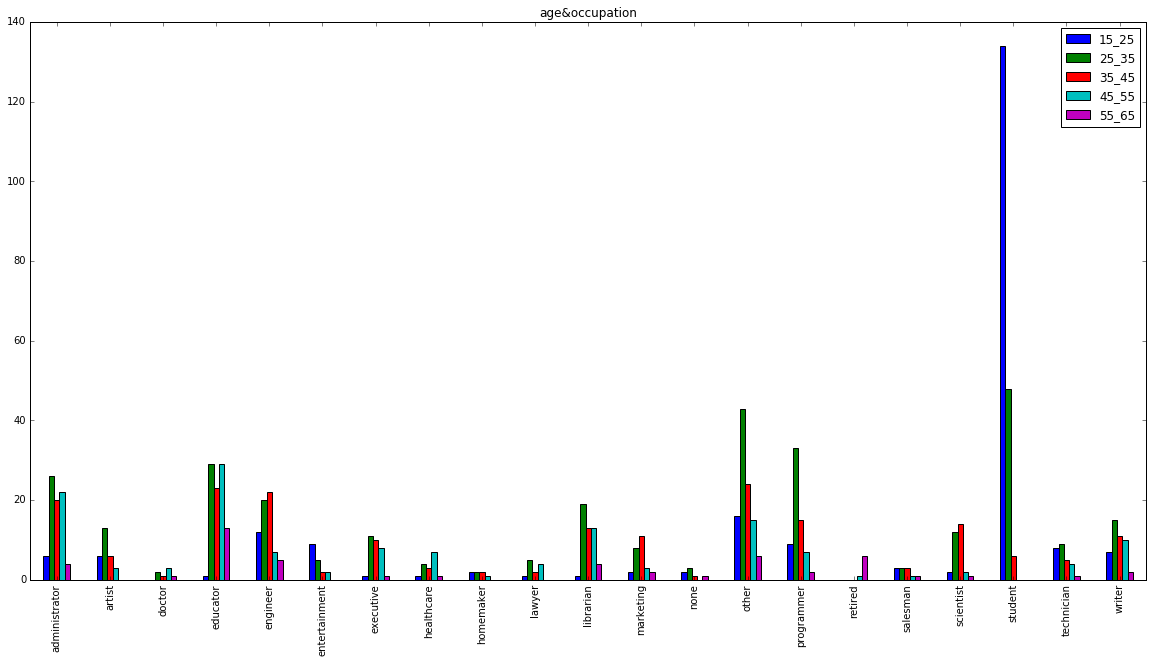

In [3]:
nf.select(nf.age.cast(DoubleType())).toPandas().hist(color='lightblue')
plt.show()
occupationDf = occupationDf.toPandas()
occupationDf.index=list(occupationDf.ix[:,0])
occupationDf['count'].plot(kind='bar')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()
genderDf = genderDf.toPandas()
genderDf.index=list(genderDf.ix[:,0])
genderDf['count'].plot(kind='bar')
plt.show()
condition="case \
when  5<=age and age<15 then 0 \
when 10<=age and age<25 then 1 \
when age>=25 and age<35 then 2 \
when age>=35 and age<45 then 3 \
when age>=45 and age<55 then 4 \
when age>=55 and age<65 then 5 \
when age>=65 and age<75 then 6 \
when age>=75 and age<85 then 7 \
end "
gdf=spark.sql("select id,"+condition+" as newage,gender,occupation,zip_code from user")
gdf.createTempView("newUser")
sqlString="with t as \
(select newage,occupation ,count(*) as count from newUser group by occupation,newage) \
select occupation, \
max(case newage when 0 then cnt else 0 end ) as 5_15,\
max(case newage when 1 then cnt else 0 end) as 15_25,\
max(case newage when 2 then cnt else 0 end) as 25_35,\
max(case newage when 3 then cnt else 0 end) as 35_45,\
max(case newage when 4 then cnt else 0 end) as 45_55,\
max(case newage when 5 then cnt else 0 end) as 55_65,\
max(case newage when 6 then cnt else 0 end) as 65_75 \
from test1 group by occupation\
"
uAndC=spark.sql(sqlString).sort(asc('occupation'))
uAndC=uAndC.toPandas()
uAndC.index=list(uAndC.ix[:,0])
uAndC.ix[:,1:]
uAndC.ix[:,2:-1].plot(kind='bar',title=u'age&occupation')
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

In [4]:
# ratingPath = "data/ml-100k/u.data"
ratingPath = "data/ml-10M/ratings.dat"
rating_data = sc.textFile(ratingPath)
def myInt(x):
    try:
        return int(x)
    except:
        return np.nan
    
    
rating_data = rating_data.map(lambda x:x.split("::")).map(lambda x:(myInt(x[0]),myInt(x[1]),myInt(x[2]),myInt(x[3])))                          
df=spark.createDataFrame(rating_data,("userid","itemid","ratings","timestamp"))
df.limit(10).show()


+------+------+-------+---------+
|userid|itemid|ratings|timestamp|
+------+------+-------+---------+
|     1|   122|      5|838985046|
|     1|   185|      5|838983525|
|     1|   231|      5|838983392|
|     1|   292|      5|838983421|
|     1|   316|      5|838983392|
|     1|   329|      5|838983392|
|     1|   355|      5|838984474|
|     1|   356|      5|838983653|
|     1|   362|      5|838984885|
|     1|   364|      5|838983707|
+------+------+-------+---------+



In [16]:
from pyspark.sql.functions import *
from pyspark.sql import functions
df.select(stat('ratings'))
print df.select(isnull('ratings').alias('r')).filter('r=true').count()
df.filter('userid=3').show()
df.select('userid','itemid','ratings').na.fill(9).filter('ratings=9').show()

2048230
+------+------+-------+----------+
|userid|itemid|ratings| timestamp|
+------+------+-------+----------+
|     3|   110|   null|1136075500|
|     3|   151|   null|1133571026|
|     3|   213|      5|1136075789|
|     3|   590|   null|1136075494|
|     3|  1148|      4|1133571121|
|     3|  1246|      4|1133570967|
|     3|  1252|      4|1133571071|
|     3|  1276|   null|1133571205|
|     3|  1288|      3|1133571035|
|     3|  1408|   null|1133571145|
|     3|  1552|      2|1133571139|
|     3|  1564|   null|1136418605|
|     3|  1597|   null|1133571226|
|     3|  1674|   null|1133571182|
|     3|  3408|      4|1164885590|
|     3|  3684|   null|1136075915|
|     3|  4535|      4|1164885526|
|     3|  4677|      4|1136075924|
|     3|  4995|   null|1133571200|
|     3|  5299|      3|1164885617|
+------+------+-------+----------+
only showing top 20 rows

+------+------+-------+
|userid|itemid|ratings|
+------+------+-------+
|     3|   110|      9|
|     3|   151|      9|
|     

In [17]:
 df.select('userid','itemid','ratings').filter('(userid=3)&(itemid=110)').limit(10).show()

AnalysisException: u"cannot resolve '((`userid` = CAST(3 AS BIGINT)) & (`itemid` = CAST(110 AS BIGINT)))' due to data type mismatch: '((`userid` = CAST(3 AS BIGINT)) & (`itemid` = CAST(110 AS BIGINT)))' requires integral type, not boolean; line 1 pos 0;\n'Filter ((userid#306L = cast(3 as bigint)) & (itemid#307L = cast(110 as bigint)))\n+- Project [userid#306L, itemid#307L, ratings#308L]\n   +- LogicalRDD [userid#306L, itemid#307L, ratings#308L, timestamp#309L]\n"

In [86]:
trainingData,cvData,testData=df.randomSplit([6.0,2.0,2.0],24)
from pyspark.ml.recommendation import ALS
from pyspark.ml import Pipeline,PipelineModel
als =ALS(rank=10,maxIter=5,seed=0,userCol="userid",itemCol="itemid",ratingCol="ratings")
recommendationModel = als.fit(trainingData)
predictionRecommendation = recommendationModel.transform(testData)
# predictionRecommendation.limit(10)
# pipeRecommendater = Pipeline(stages=[])    

# predictionRecommendation.select(isnull("ratings").alias("if")).filter("if == false").show()
# predictionRecommendation.select(isnull("prediction").alias("if")).filter("if != false").show()
predictionRecommendation.show()
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator()\
      .setMetricName("rmse")\
      .setLabelCol("ratings")\
      .setPredictionCol("prediction")
rmse = evaluator.evaluate(predictionRecommendation.na.drop())
print "RMSE:",rmse

+------+------+-------+----------+----------+
|userid|itemid|ratings| timestamp|prediction|
+------+------+-------+----------+----------+
| 27042|   148|      3| 831639909| 3.1525528|
| 55356|   148|      4| 828042393| 3.4554834|
|  4153|   148|      3|1111644815| 2.5864236|
| 57126|   148|      2|1182634429| 3.0205884|
|  5764|   148|      1| 834319825|  2.794425|
| 17444|   148|      3|1058985403| 2.8927464|
| 37556|   148|      1| 833918571| 2.6493483|
| 18059|   148|      4| 982974434|  2.813229|
| 60154|   148|      2| 835094487| 2.8196478|
| 32346|   148|      5| 836474986| 3.4753885|
| 58010|   148|      1| 837770520|  2.697298|
|  5676|   148|      1| 828145470|  3.601865|
| 67972|   148|      3| 833017056| 2.9609938|
| 62962|   148|      3| 838135533|  2.739515|
| 52552|   148|      3| 947200668| 2.6045685|
| 57494|   148|      5| 978407639| 3.4095302|
| 15012|   148|      3| 832686930|  2.797998|
| 65957|   148|      3| 838407261|  2.912557|
| 37392|   148|      3| 948831793|

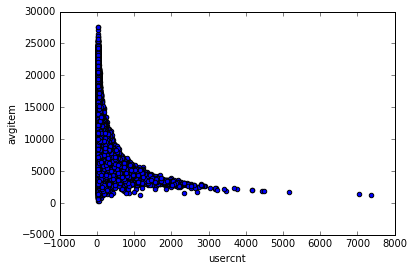

In [18]:
df.registerTempTable('df')
# "with t1 as (select count(distinct(age)) as ages from user),\
#            t2 as (select count(distinct(gender)) as genders from user), \
#            t3 as (select count(distinct(occupation)) as occupations from user) \
#             select * from t1 cross join t2 cross join t3"
sqlString ="with t1 as (select itemid,count(itemid) as itemcnt from df group by itemid),\
            t2 as (select userid,count(userid) as usercnt from df group by userid),\
            t3 as (select userid,df.itemid,itemcnt from df,t1 \
            where t1.itemid=df.itemid sort by userid desc),\
            t4 as (select userid,sum(itemcnt)/count(itemcnt) as avgitem from t3 group by userid) \
            select t2.usercnt,t4.avgitem from t4 left join t2 on t2.userid=t4.userid"
# spark.sql("select userid,itemid,count(itemid) as cnt from df group by userid,itemid').show()
pDf = spark.sql(sqlString).toPandas()
# pDf.set_index=pDf['usercnt']
pDf.plot(x='usercnt',y='avgitem',kind='scatter')
# print df.count()
# print df.groupBy('timestamp','itemid').count().withColumnRenamed('count','cnt').sort(desc('cnt')).count()
# print df.groupBy('timestamp','userid').count().withColumnRenamed('count','cnt').sort(desc('cnt')).count()

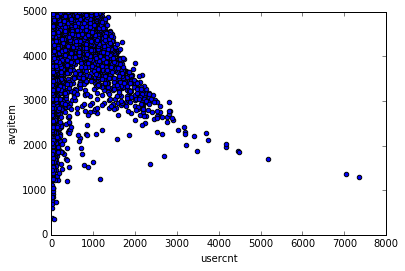

In [32]:
import matplotlib.pyplot as plt
pDf.plot(x='usercnt',y='avgitem',kind='scatter')
plt.axis([0,8000,0,5000])
plt.show()

In [16]:
!hadoop fs -ls -h /user/yanbin/data/ml-100k/

Found 23 items
-rw-r--r--   1 yanbin supergroup      6.6 K 2017-05-18 16:51 /user/yanbin/data/ml-100k/README
-rw-r--r--   1 yanbin supergroup        716 2017-05-18 16:51 /user/yanbin/data/ml-100k/allbut.pl
-rw-r--r--   1 yanbin supergroup        643 2017-05-18 16:51 /user/yanbin/data/ml-100k/mku.sh
-rw-r--r--   1 yanbin supergroup      1.9 M 2017-05-18 16:51 /user/yanbin/data/ml-100k/u.data
-rw-r--r--   1 yanbin supergroup        202 2017-05-18 16:51 /user/yanbin/data/ml-100k/u.genre
-rw-r--r--   1 yanbin supergroup         36 2017-05-18 16:51 /user/yanbin/data/ml-100k/u.info
-rw-r--r--   1 yanbin supergroup    230.8 K 2017-05-18 16:51 /user/yanbin/data/ml-100k/u.item
-rw-r--r--   1 yanbin supergroup        193 2017-05-18 16:51 /user/yanbin/data/ml-100k/u.occupation
-rw-r--r--   1 yanbin supergroup     22.1 K 2017-05-18 16:51 /user/yanbin/data/ml-100k/u.user
-rw-r--r--   1 yanbin supergroup      1.5 M 2017-05-18 16:51 /user/yanbin/data/ml-100k/u1.base
-rw-r--r--   1 yanbin supergroup  